# Detrended Partial Cross Correlation in Python
**Author: Jaime Ide (jaime.ide@yale.edu),
Date: Feb 15, 2018**

Simple code to compute the detrended partial cross correlation analysis (DPCCA) coefficient. It is simple, but since I didn't find any code in Python, I decided to post it here. In addition to DPCCA, I also compute the DCCA, correlation and partial correlation matrixes as well so that you can compare them. Credits to Pitithat Puranachot who posted a version of the DCCA in R (CrossValidated). I have the Matlab code version too. Just send me a message if you need it.

- **References:** 

[1] Ladislav Kristoufek. _Measuring correlations between non-stationary series with DCCA coefficient_, Physica A: Statistical Mechanics and its Applications, Volume 402, Pages 291-298, ISSN 0378-4371, 2014.
https://doi.org/10.1016/j.physa.2014.01.058.

[2] Yuan, N. et al. _Detrended Partial-Cross-Correlation Analysis: A New Method for Analyzing Correlations in Complex System_, Scientific Reports, 5, Issue 8143, 2015.

- **If you want to give credit for the code, please reference my work at NIPS2017:**

[3] Ide,JS; Cappabianco,FA; Faria,FA; Li,CSR. _Detrended Partial Cross Correlation for Brain Connectivity Analysis_. Advances in Neural Information Processing Systems 30, pages: 889--897, 2017 http://papers.nips.cc/paper/6690-detrended-partial-cross-correlation-for-brain-connectivity-analysis.pdf


# 1. Computing DPCCA (step-by-step)

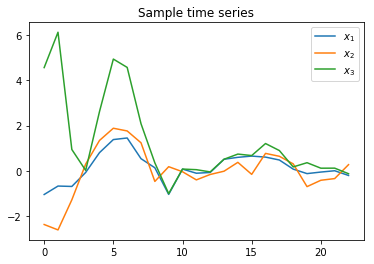

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat

%matplotlib inline

# Simple time-series (from CrossValidated so that you can compare the results)
x1 = [-1.042061,-0.669056,-0.685977,-0.067925,0.808380,1.385235,1.455245,0.540762 ,0.139570,-1.038133,0.080121,-0.102159,-0.068675,0.515445,0.600459,0.655325,0.610604,0.482337,0.079108,-0.118951,-0.050178,0.007500,-0.200622]
x2 = [-2.368030,-2.607095,-1.277660,0.301499,1.346982,1.885968,1.765950,1.242890,-0.464786,0.186658,-0.036450,-0.396513,-0.157115,-0.012962,0.378752,-0.151658,0.774253,0.646541,0.311877,-0.694177,-0.412918,-0.338630,0.276635]
x3 = np.array(x1)+np.array(x2)**2 # ad hoc

# Plot
cdata = np.array([x1,x2,x3]).T
plt.plot(cdata)
plt.title('Sample time series')
plt.legend(['$x_1$','$x_2$','$x_3$'])

(23, 3)

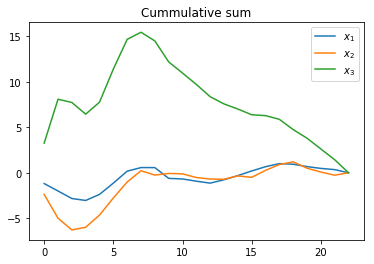

In [3]:
# Define
nsamples,nvars = cdata.shape

# Cummulative sum after removing mean
cdata = cdata-cdata.mean(axis=0)
xx = np.cumsum(cdata,axis=0)
plt.plot(xx)
plt.title('Cummulative sum')
plt.legend(['$x_1$','$x_2$','$x_3$'])
xx.shape

In [4]:
# Return sliding windows
import numpy as np

def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    
    # generate indexes. O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx

In [5]:
# Compute Eq.4
k = 4
F2_dfa_x = np.zeros(nvars)
allxdif = []
for ivar in range(nvars): # do for all vars
    xx_swin , idx = sliding_window(xx[:,ivar],k)
    nwin = xx_swin.shape[0]
    b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit
    #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # slow version
    x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    # Store differences to the linear fit
    xdif = xx_swin-x_hatx
    allxdif.append(xdif)
    # Eq.4
    F2_dfa_x[ivar] = (xdif**2).mean()

In [6]:
# Get the DCCA matrix
dcca = np.zeros([nvars,nvars])
for i in range(nvars): # do for all vars
    for j in range(nvars): # do for all vars
        # Eq.5 and 6
        F2_dcca = (allxdif[i]*allxdif[j]).mean()
        # Eq.1: DCCA
        dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])

dcca

array([[ 1.        ,  0.62664048,  0.62095623],
       [ 0.62664048,  1.        ,  0.1783183 ],
       [ 0.62095623,  0.1783183 ,  1.        ]])

In [7]:
# Get DPCCA
C = np.linalg.inv(dcca)
dpcca = np.zeros([nvars,nvars])
for i in range(nvars):
    for j in range(nvars):
        dpcca[i,j] = -C[i,j]/np.sqrt(C[i,i]*C[j,j]);
dpcca

array([[-1.        ,  0.66890233,  0.66406175],
       [ 0.66890233, -1.        , -0.34508556],
       [ 0.66406175, -0.34508556, -1.        ]])

In [8]:
# Compute Corr (for the parCorr)
corr = np.corrcoef(cdata.T)
cov = np.cov(cdata.T)
# Get parCorr
C0 = np.linalg.inv(cov)
mydiag = np.sqrt(np.abs(np.diag(C0)))
# Efficient computation
(-C0/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)

array([[ 1.        ,  0.84980211,  0.49768411],
       [ 0.84980211,  1.        , -0.45946314],
       [ 0.49768411, -0.45946314,  1.        ]])

# 2. Function to compute DPCCA

In [9]:
import numpy as np
from numpy.matlib import repmat

# Return sliding windows
def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    
    # generate indexes! O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx

def compute_dpcca_others(cdata,k):
    # Input: cdata(nsamples,nvars), k: time scale for dpcca
    # Output: dcca, dpcca, corr, partialCorr
    #
    # Date(last modification): 02/15/2018
    # Author: Jaime Ide (jaime.ide@yale.edu)
    
    # Code distributed "as is", in the hope that it will be useful, but WITHOUT ANY WARRANTY;
    # without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
    # See the GNU General Public License for more details.
    
    # Define
    nsamples,nvars = cdata.shape

    # Cummulative sum after removing mean
    #cdata = signal.detrend(cdata,axis=0) # different from only removing the mean...
    cdata = cdata-cdata.mean(axis=0)
    
    F2_dfa_x = np.zeros(nvars)
    allxdif = []
    # Get alldif and F2_dfa
    for ivar in range(nvars): # do for all vars
        xx_swin , idx = sliding_window(xx[:,ivar],k)
        nwin = xx_swin.shape[0]
        b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit (UPDATE if needed)
        
        #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # Slower version
        x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    
        # Store differences to the linear fit
        xdif = xx_swin-x_hatx
        allxdif.append(xdif)
        # Eq.4
        F2_dfa_x[ivar] = (xdif**2).mean()
    # Get the DCCA matrix
    dcca = np.zeros([nvars,nvars])
    for i in range(nvars): # do for all vars
        for j in range(nvars): # do for all vars
            # Eq.5 and 6
            F2_dcca = (allxdif[i]*allxdif[j]).mean()
            # Eq.1: DCCA
            dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])   
    
    # Get DPCCA
    C = np.linalg.inv(dcca)
    
    # (Clear but slow version)
    #dpcca = np.zeros([nvars,nvars])
    #for i in range(nvars):
    #    for j in range(nvars):
    #        dpcca[i,j] = -C[i,j]/np.sqrt(C[i,i]*C[j,j])
    
    # DPCCA (oneliner version)
    mydiag = np.sqrt(np.abs(np.diag(C)))
    dpcca = (-C/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    # Include correlation and partial corr just for comparison ;)
    # Compute Corr
    corr = np.corrcoef(cdata.T)
    # Get parCorr
    C0 = np.linalg.inv(cov)
    mydiag = np.sqrt(np.abs(np.diag(C0)))
    parCorr = (-C0/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    return corr,parCorr,dcca,dpcca

In [10]:
# Example using the function
k = 6
corr,parCorr,dcca, dpcca = compute_dpcca_others(cdata,k)
print('Pearson:\n',corr)
print('PartialCorr:\n',parCorr)
print('DCCA(k={}):\n{}'.format(k,dcca))
print('DPCCA(k={}):\n{}'.format(k,dpcca))


Pearson:
 [[ 1.          0.80626524  0.22904353]
 [ 0.80626524  1.         -0.0799021 ]
 [ 0.22904353 -0.0799021   1.        ]]
PartialCorr:
 [[ 1.          0.84980211  0.49768411]
 [ 0.84980211  1.         -0.45946314]
 [ 0.49768411 -0.45946314  1.        ]]
DCCA(k=6):
[[ 1.          0.8198706   0.82176979]
 [ 0.8198706   1.          0.60633106]
 [ 0.82176979  0.60633106  1.        ]]
DPCCA(k=6):
[[ 1.          0.70974722  0.71306451]
 [ 0.70974722  1.         -0.20663271]
 [ 0.71306451 -0.20663271  1.        ]]
